## UHF Coefficient Matrix Trials
RHF and UHF self-consistent methods require an initial guess of the coeficient matrix (transforms basis orbitals to molecular orbitals).
This first cell demonstrates how to calculate RHF and UHF coefficient matrices for H$_2$ and prints them.

In [2]:
import numpy as np
from pyscf import gto, scf, fci

# Create a stretched/dissociated hydrogen molecule
bond_length = 5
mol = gto.Mole()
mol.atom = f"H 0 0 0; H 0 0 {bond_length}"  # in Angstrom by default
mol.basis = "STO-3G"  # minimal basis, 1s from each H atom, two molecular orbitals
mol.charge = 0
mol.spin = 0  # number of unpaired electrons: 0 => singlet (default)
mol.verbose = 3  # print the converged energy and spin information
mol.build()

# Restricted Hartree-Fock (RHF)
# Number of alpha and beta spins in each orbital are equal
mf_rhf = scf.RHF(mol)  # create meanfield object
energy = mf_rhf.kernel()  # run RHF

# Unrestricted Hartree-Fock (UHF)
# Number of alpha and beta spins in each orbital can differ
mf_uhf = scf.UHF(mol)  # create meanfield object
mf_uhf.kernel()  # run UHF

# Print the coefficient matrices for RHF & UHF
# The matrices are properties of the meanfield objects
rhf_c = mf_rhf.mo_coeff
print("\nRHF coefficient matrix:")
print(rhf_c)

# UHF has separate matrices for the alpha and beta spins
uhf_ca, uhf_cb = mf_uhf.mo_coeff
print("\nUHF coefficient matrices:")
print("\u03b1")  # unicode alpha
print(uhf_ca)
print("\u03b2")  # unicode beta
print(uhf_cb)

converged SCF energy = -0.599024871506153
converged SCF energy = -0.599024871506153  <S^2> = -4.4408921e-16  2S+1 = 1

RHF coefficient matrix:
[[ 0.70706866 -0.70714491]
 [ 0.70706866  0.70714491]]

UHF coefficient matrices:
α
[[ 0.70706866 -0.70714491]
 [ 0.70706866  0.70714491]]
β
[[ 0.70706866 -0.70714491]
 [ 0.70706866  0.70714491]]


# Calculate energy from RHF and UHF

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from pyscf import gto, scf, fci

# Create hydrogen molecule over changing bond lengths
bond_length = 5

# Create hydrogen molecule object
mol = gto.Mole()
mol.atom = f"H 0 0 0; H 0 0 {bond_length}"  # in Angstrom by default
mol.basis = "STO-3G"  # minimal basis, 1s from each H atom, two molecular orbitals
mol.charge = 0
mol.spin = 0  # number of unpaired electrons: 0 => singlet (default)
mol.verbose = 3
mol.build()

# Restricted Hartree-Fock (RHF)
# Number of alpha and beta spins in each orbital are equal
mf_rhf = scf.RHF(mol)  # create meanfield object
rhf_energy = mf_rhf.kernel()  # run RHF

# Unrestricted Hartree-Fock (UHF)
# Number of alpha and beta spins in each orbital can differ
mf_uhf = scf.UHF(mol)  # create meanfield object
mf_uhf.mo_coeff = [[1, 0], [0, 1]] * 2
uhf_energy = mf_uhf.kernel()  # run UHF

ci_solver = fci.FCI(mol, mf_rhf.mo_coeff)
fci_energy = ci_solver.kernel()[0]

print(rhf_energy, uhf_energy, fci_energy)

converged SCF energy = -0.599024871506153
converged SCF energy = -0.599024871506153  <S^2> = -4.4408921e-16  2S+1 = 1
-0.5990248715061534 -0.5990248715061532 -0.9331637619303779


# Rotation matrix

Here the UHF is just the same as the RHF. So we will rotate the coeff of the initial guess. Lets start with the rotation matrix.

In [4]:
import numpy as np
from scipy.linalg import expm

angle = 0.25 * np.pi
q = expm([[0, -angle], [angle, 0]])

print("Q (anticlockwise)")
print(q)
print("\nQ transpose (clockwise)")
print(q.T)

Q (anticlockwise)
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]

Q transpose (clockwise)
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]


# Rotate coefficient matrix

Apply a rotation to the RHF coefficient matrix and use this as the UHF initial state.
I have discovered you must update mo_occ property in order for the updated mo_coeff to have an effect.
This doesn't seem like an intended use of PySCF.
It is perhaps better in future to build the density matrices and pass those to the SCF.

In [5]:
import numpy as np
from scipy.linalg import expm
from pyscf import gto, scf, fci

# Create a stretched/dissociated hydrogen molecule
bond_length = 5
mol = gto.Mole()
mol.unit = "Angstrom" # in Angstrom by default, just being explicit
mol.atom = f"H 0 0 0; H 0 0 {bond_length}"
mol.basis = "STO-3G" # minimal basis, 1s from each H atom, two molecular orbitals
mol.charge = 0
mol.spin = 0 # number of unpaired electrons: 0 => singlet (default)
mol.verbose = 3 # print the converged energy and spin information
mol.build()

# Use RHF soln as the starting point for UHF
mf_rhf = scf.RHF(mol)
rhf_energy = mf_rhf.kernel()
ca = cb = mf_rhf.mo_coeff # alpha and beta coeff matrices

print("\nRHF coefficient matrix:")
print(mf_rhf.mo_coeff)

# Rotate the coeff matrix
angle = 0.25 * np.pi
q = expm(np.array([[0, -angle], [angle, 0]]))  # a rotation matrix
ca = ca @ q  # rotation q is rotating basis before coefficient matrix is applied
cb = cb @ q.T  # rotate in opposite direction

print("\nUFH coefficient matrix \u03b1:")
print(ca)
print("\nUFH coefficient matrix \u03b2:")
print(cb)
print('\n')

# Unrestricted Hartree-Fock (UHF)
# Number of alpha and beta spins in each orbital can differ
mf_uhf = scf.UHF(mol)  # create meanfield object
mf_uhf.mo_coeff = ca, cb  # set rotated coeff matrices
mf_uhf.mo_occ = [1, 0], [1, 0] # a/b MO occupations
uhf_energy = mf_uhf.kernel()  # run UHF

ca, cb = mf_uhf.mo_coeff
print("\nUFH coefficient matrix \u03b1:")
print(ca)
print("\nUFH coefficient matrix \u03b2:")
print(cb)

cisolver = fci.FCI(mol, mf_rhf.mo_coeff)
fci_energy = cisolver.kernel()[0]

print("\nRHF:", rhf_energy)
print("UHF:", uhf_energy)
print("FCI:", fci_energy)

converged SCF energy = -0.599024871506153

RHF coefficient matrix:
[[ 0.70706866 -0.70714491]
 [ 0.70706866  0.70714491]]

UFH coefficient matrix α:
[[-5.39167723e-05 -1.00000000e+00]
 [ 1.00000000e+00  5.39167796e-05]]

UFH coefficient matrix β:
[[ 1.00000000e+00 -5.39167723e-05]
 [-5.39167796e-05  1.00000000e+00]]


converged SCF energy = -0.933163722004874  <S^2> = 0.99999986  2S+1 = 2.2360679

UFH coefficient matrix α:
[[ 1.29873191e-04  9.99999997e-01]
 [ 9.99999978e-01 -2.37706741e-04]]

UFH coefficient matrix β:
[[ 9.99999978e-01 -2.37706741e-04]
 [ 1.29873191e-04  9.99999997e-01]]

RHF: -0.5990248715061534
UHF: -0.9331637220048741
FCI: -0.9331637619303779


So we have demonstrated the UHF energy is closer to FCI at stretched bond lengths. Let's try a few mixing angles over a range of bond lengths.

# Symmetric $\alpha$ and $\beta$ coefficient rotations
Rotate the alpha and beta coefficient matrices by the same angle in opposite directions.

Text(0, 0.5, 'energy / Ha')

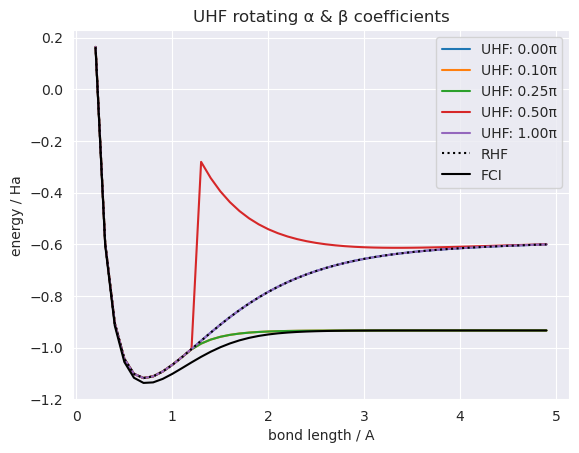

In [9]:
import numpy as np
from scipy.linalg import expm
from pyscf import gto, scf, fci

fci_energies: list[float] = []
rhf_energies: list[float] = []
uhf_energies: list[float] = []

# Create hydrogen molecule over changing bond lengths
bond_lengths = np.arange(0.2, 5, 0.1)
angles = np.array([0, 0.1, 0.25, 0.5, 1]) * np.pi

for bond_length in bond_lengths:
    mol = gto.Mole()
    mol.atom = f"H 0 0 0; H 0 0 {bond_length}"  # in Angstrom by default
    mol.basis = "STO-3G"  # minimal basis, 1s from each H atom, two molecular orbitals
    mol.charge = 0
    mol.spin = 0  # number of unpaired electrons: 0 => singlet (default)
    mol.verbose = 0  # no printing, too many bond lengths
    mol.build()

    # Restricted Hartree-Fock (RHF)
    # Number of alpha and beta spins in each orbital are equal
    mf_rhf = scf.RHF(mol)  # create meanfield object
    rhf_energy = mf_rhf.kernel()  # run RHF
    rhf_energies.append(rhf_energy)  # save RHF energy

    for angle in angles:
        # Rotation matrix
        q = expm(np.array([[0, -angle], [angle, 0]]))

        # Rotate coeff matrices
        ca = cb = mf_rhf.mo_coeff
        ca = ca @ q
        cb = cb @ q.T # opposite rotation to break spin symmetry

        mf_uhf = scf.UHF(mol) # create meanfield object
        mf_uhf.mo_coeff = [ca, cb] # set initial coeffs
        mf_uhf.mo_occ = [1, 0], [1, 0] # required for updated mo_coeff to be used

        # Run UHF and save data
        uhf_energy = mf_uhf.kernel()
        uhf_energies.append(uhf_energy)

    # FCI energy
    cisolver = fci.FCI(mol, mf_rhf.mo_coeff)
    fci_energy = cisolver.kernel()[0]
    fci_energies.append(fci_energy)

# Reshape UHF energies, grouping by the mixing angle that was used
chunk = len(angles)
uhf_energies = [uhf_energies[i:i+chunk] for i in range(0, len(uhf_energies), chunk)]
uhf_energies = list(zip(*uhf_energies))

from matplotlib import pyplot as plt

for i, uhf_energy in enumerate(uhf_energies):
    angle = angles[i] / np.pi
    plt.plot(bond_lengths, uhf_energy, label=f"UHF: {angle:.2f}\u03c0")
plt.plot(bond_lengths, rhf_energies, 'k:', label="RHF")
plt.plot(bond_lengths, fci_energies, 'k', label="FCI")
plt.legend()
plt.title("UHF rotating \u03b1 & \u03b2 coefficients")
plt.xlabel("bond length / A")
plt.ylabel("energy / Ha")

# Assymetric $\alpha$ and $\beta$ rotations

Only rotate the alpha coefficient matrix. Leave the beta coefficients as the RHF.

Text(0, 0.5, 'energy / Ha')

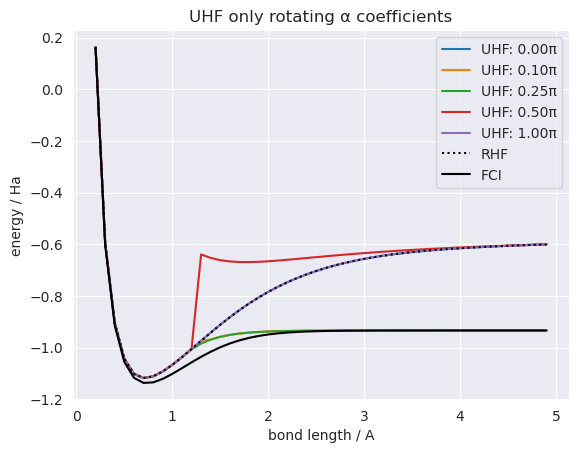

In [8]:
import numpy as np
from scipy.linalg import expm
from pyscf import gto, scf, fci

fci_energies: list[float] = []
rhf_energies: list[float] = []
uhf_energies: list[float] = []

# Create hydrogen molecule over changing bond lengths
bond_lengths = np.arange(0.2, 5, 0.1)
angles = np.array([0, 0.1, 0.25, 0.5, 1]) * np.pi

for bond_length in bond_lengths:
    mol = gto.Mole()
    mol.atom = f"H 0 0 0; H 0 0 {bond_length}"  # in Angstrom by default
    mol.basis = "STO-3G"  # minimal basis, 1s from each H atom, two molecular orbitals
    mol.charge = 0
    mol.spin = 0  # number of unpaired electrons: 0 => singlet (default)
    mol.verbose = 0  # no printing, too many bond lengths
    mol.build()

    # Restricted Hartree-Fock (RHF)
    # Number of alpha and beta spins in each orbital are equal
    mf_rhf = scf.RHF(mol)  # create meanfield object
    rhf_energy = mf_rhf.kernel()  # run RHF
    rhf_energies.append(rhf_energy)  # save RHF energy

    for angle in angles:
        # Rotation matrix
        q = expm(np.array([[0, -angle], [angle, 0]]))

        # Rotate coeff matrices
        ca = cb = mf_rhf.mo_coeff
        ca = ca @ q
        # cb = cb @ q.T # opposite rotation to break spin symmetry

        mf_uhf = scf.UHF(mol) # create meanfield object
        mf_uhf.mo_coeff = [ca, cb] # set initial coeffs
        mf_uhf.mo_occ = [1, 0], [1, 0] # required for updated mo_coeff to be used

        # Run UHF and save data
        uhf_energy = mf_uhf.kernel()
        uhf_energies.append(uhf_energy)

    # FCI energy
    cisolver = fci.FCI(mol, mf_rhf.mo_coeff)
    fci_energy = cisolver.kernel()[0]
    fci_energies.append(fci_energy)

# Reshape UHF energies, grouping by the mixing angle that was used
chunk = len(angles)
uhf_energies = [uhf_energies[i:i+chunk] for i in range(0, len(uhf_energies), chunk)]
uhf_energies = list(zip(*uhf_energies))

from matplotlib import pyplot as plt

for i, uhf_energy in enumerate(uhf_energies):
    angle = angles[i] / np.pi
    plt.plot(bond_lengths, uhf_energy, label=f"UHF: {angle:.2f}\u03c0")
plt.plot(bond_lengths, rhf_energies, 'k:', label="RHF")
plt.plot(bond_lengths, fci_energies, 'k', label="FCI")
plt.legend()
plt.title("UHF only rotating \u03b1 coefficients")
plt.xlabel("bond length / A")
plt.ylabel("energy / Ha")

# Compare only $\alpha$ rotations to rotating both coefficient matrices

Text(0, 0.5, 'energy / Ha')

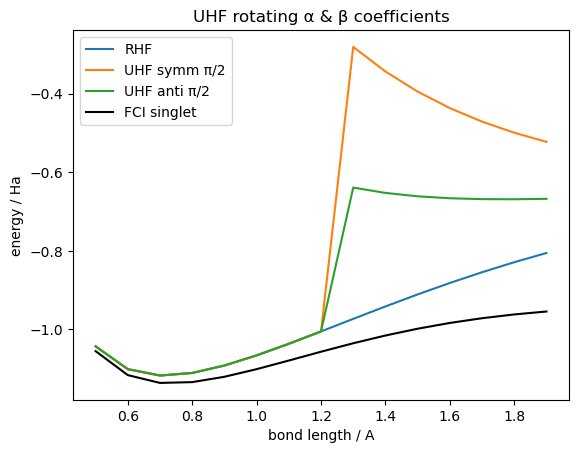

In [1]:
import numpy as np
from scipy.linalg import expm
from pyscf import gto, scf, fci


fci_energies_singlet = []
fci_energies_triplet = []
rhf_energies = []
uhf_energies_symm = []
uhf_energies_anti = []

# Create hydrogen molecule over changing bond lengths
bond_lengths = np.arange(0.5, 2, 0.1)

# 0 angle is RHF, pi/2 is flipping to the excited RHF solution
angles = np.array([0.5]) * np.pi

# Symmetric rotation of alpha and beta coeff matrices
for bond_length in bond_lengths:
    mol = gto.Mole()
    mol.atom = f"H 0 0 0; H 0 0 {bond_length}"  # in Angstrom by default
    mol.basis = "STO-3G"  # minimal basis, 1s from each H atom, two molecular orbitals
    mol.charge = 0
    mol.spin = 0  # number of unpaired electrons: 0 => singlet (default)
    mol.verbose = 0  # no printing, too many bond lengths
    mol.build()

    # Restricted Hartree-Fock (RHF)
    # Number of alpha and beta spins in each orbital are equal
    mf_rhf = scf.RHF(mol)  # create meanfield object
    rhf_energy = mf_rhf.kernel() # run RHF
    rhf_energies.append(rhf_energy)

    for angle in angles:
        # Rotation matrix
        q = expm(np.array([[0, -angle], [angle, 0]]))

        # Rotate coeff matrices
        ca = cb = mf_rhf.mo_coeff
        ca = ca @ q
        cb = cb @ q.T # opposite rotation to break spin symmetry

        mf_uhf = scf.UHF(mol) # create meanfield object
        mf_uhf.mo_coeff = [ca, cb] # set initial coeffs
        mf_uhf.mo_occ = [1, 0], [1, 0] # required for updated mo_coeff to be used

        # Run UHF and save data
        uhf_energy = mf_uhf.kernel()
        uhf_energies_symm.append(uhf_energy)

    # FCI energy
    cisolver = fci.FCI(mol, mf_rhf.mo_coeff)
    # cisolver.nroots = 2
    fci_energy = cisolver.kernel()[0]
    fci_energies_singlet.append(fci_energy)

# Antisymmetric rotation, rotate alpha coeffs only
for bond_length in bond_lengths:
    mol = gto.Mole()
    mol.atom = f"H 0 0 0; H 0 0 {bond_length}"  # in Angstrom by default
    mol.basis = "STO-3G"  # minimal basis, 1s from each H atom, two molecular orbitals
    mol.charge = 0
    mol.spin = 0  # number of unpaired electrons: 0 => singlet (default)
    mol.verbose = 0  # no printing, too many bond lengths
    mol.build()

    # Restricted Hartree-Fock (RHF)
    # Number of alpha and beta spins in each orbital are equal
    mf_rhf = scf.RHF(mol)  # create meanfield object
    mf_rhf.kernel() # run RHF

    for angle in angles:
        # Rotation matrix
        q = expm(np.array([[0, -angle], [angle, 0]]))

        # Rotate coeff matrices
        ca = cb = mf_rhf.mo_coeff
        ca = ca @ q # only rotate alpha coeffs not beta coeffs

        mf_uhf = scf.UHF(mol) # create meanfield object
        mf_uhf.mo_coeff = [ca, cb] # set initial coeffs
        mf_uhf.mo_occ = [1, 0], [1, 0] # required for updated mo_coeff to be used

        # Run UHF and save data
        uhf_energy = mf_uhf.kernel()
        uhf_energies_anti.append(uhf_energy)

# Run triplet
triplet = False
if triplet:
    for bond_length in bond_lengths:
        mol = gto.Mole()
        mol.atom = f"H 0 0 0; H 0 0 {bond_length}"  # in Angstrom by default
        mol.basis = "STO-3G"  # minimal basis, 1s from each H atom, two molecular orbitals
        mol.charge = 0
        mol.spin = 2  # number of unpaired electrons: 2 => triplet
        mol.verbose = 0  # no printing, too many bond lengths
        mol.build()

        # Restricted Hartree-Fock (RHF)
        # Number of alpha and beta spins in each orbital are equal
        mf_rhf = scf.RHF(mol)  # create meanfield object
        mf_rhf.kernel() # run RHF

        # FCI energy
        cisolver = fci.FCI(mol, mf_rhf.mo_coeff)
        # cisolver.nroots = 2
        fci_energy = cisolver.kernel()[0]
        fci_energies_triplet.append(fci_energy)

# Plot the potential energy curves
from matplotlib import pyplot as plt

plt.plot(bond_lengths, rhf_energies, label="RHF")
plt.plot(bond_lengths, uhf_energies_symm, label=f"UHF symm \u03c0/2")
plt.plot(bond_lengths, uhf_energies_anti, label=f"UHF anti \u03c0/2")

plt.plot(bond_lengths, fci_energies_singlet, 'k', label="FCI singlet")
if triplet:
    plt.plot(bond_lengths, fci_energies_triplet, 'k:', label="FCI triplet")

plt.legend()
plt.title("UHF rotating \u03b1 & \u03b2 coefficients")
plt.xlabel("bond length / A")
plt.ylabel("energy / Ha")

# Use PySCF Stability Analysis

In [4]:
from pyscf import gto, scf
from pyscf.scf import stability

# Build the molecule
mol = gto.Mole()
mol.unit = "Angstrom" # in Angstrom by default but make it explicit
mol.atom = f"H 0 0 0; H 0 0 5"
mol.basis = "STO-3G"  # minimal basis, 1s from each H atom, two molecular orbitals
mol.charge = 0
mol.spin = 0 # number of unpaired electrons: 0 => singlet (default)
mol.verbose = 3 # print energies
mol.build()

# RHF
mf = scf.RHF(mol).run()

# RHF stability: check both internal (RHF→RHF) and external (RHF→UHF / real→complex)
mo_i, mo_e, stable_i, stable_e = stability.rhf_stability(
    mf, internal=True, external=True, return_status=True
)

print("\nRHF internal stable? ", stable_i)
print("RHF external (RHF→UHF/complex) stable? ", stable_e)
print("\nmo_i:\n", mo_i)
print("mo_e a:\n", mo_e[0])
print("mo_e b:\n", mo_e[1])


converged SCF energy = -0.599024871506153
<class 'pyscf.scf.hf.RHF'> wavefunction is stable in the internal stability analysis
<class 'pyscf.scf.hf.RHF'> wavefunction is stable in the real -> complex stability analysis
<class 'pyscf.scf.hf.RHF'> wavefunction has an RHF/RKS -> UHF/UKS instability

RHF internal stable?  True
RHF external (RHF→UHF/complex) stable?  False

mo_i:
 [[ 0.70706866 -0.70714491]
 [ 0.70706866  0.70714491]]
mo_e a:
 [[-0.2130111  -0.97704979]
 [ 0.97707275 -0.21290574]]
mo_e b:
 [[ 0.70706866 -0.70714491]
 [ 0.70706866  0.70714491]]


So the stability code works by rotating the $\alpha$ coeff and leaving the $\beta$ as the RHF, this still breaks spin symmetry.

In [8]:
mf_rhf.stability()

(array([[ 0.70705518,  0.7071584 ],
        [ 0.70705518, -0.7071584 ]]),
 None)

# Plot mixing angle vs bond length

In [40]:
import numpy as np
from scipy.linalg import expm
from pyscf import gto, scf, fci

fci_energies: list[float] = []
rhf_energies: list[float] = []
uhf_energies: list[float] = []

# Create hydrogen molecule over changing bond lengths
bond_lengths = np.arange(0.2, 5, 0.1)
angles = np.linspace(0, 0.5, 11) * np.pi

for bond_length in bond_lengths:
    mol = gto.Mole()
    mol.atom = f"H 0 0 0; H 0 0 {bond_length}"  # in Angstrom by default
    mol.basis = "STO-3G"  # minimal basis, 1s from each H atom, two molecular orbitals
    mol.charge = 0
    mol.spin = 0  # number of unpaired electrons: 0 => singlet (default)
    mol.verbose = 2  # no printing, too many bond lengths
    mol.build()

    # Restricted Hartree-Fock (RHF)
    # Number of alpha and beta spins in each orbital are equal
    mf_rhf = scf.RHF(mol)  # create meanfield object
    rhf_energy = mf_rhf.kernel()  # run RHF
    rhf_energies.append(rhf_energy)  # save RHF energy

    for angle in angles:
        print(f"length, angle: {bond_length:.2f}, {angle:.2f}")

        # Rotation matrix
        q = expm(np.array([[0, -angle], [angle, 0]]))

        # Rotate coeff matrices
        ca = cb = mf_rhf.mo_coeff
        ca = ca @ q
        cb = cb @ q.T # opposite rotation to break spin symmetry

        mf_uhf = scf.UHF(mol) # create meanfield object
        mf_uhf.mo_coeff = [ca, cb] # set initial coeffs
        mf_uhf.mo_occ = [1, 0], [1, 0] # required for updated mo_coeff to be used

        # Run UHF and save data
        uhf_energy = mf_uhf.kernel()
        uhf_energies.append(uhf_energy)

    # FCI energy
    cisolver = fci.FCI(mol, mf_rhf.mo_coeff)
    fci_energy = cisolver.kernel()[0]
    fci_energies.append(fci_energy)

length, angle: 0.20, 0.00
length, angle: 0.20, 0.16
length, angle: 0.20, 0.31
length, angle: 0.20, 0.47
length, angle: 0.20, 0.63
length, angle: 0.20, 0.79
length, angle: 0.20, 0.94
length, angle: 0.20, 1.10
length, angle: 0.20, 1.26
length, angle: 0.20, 1.41
length, angle: 0.20, 1.57
length, angle: 0.30, 0.00
length, angle: 0.30, 0.16
length, angle: 0.30, 0.31
length, angle: 0.30, 0.47
length, angle: 0.30, 0.63
length, angle: 0.30, 0.79
length, angle: 0.30, 0.94
length, angle: 0.30, 1.10
length, angle: 0.30, 1.26
length, angle: 0.30, 1.41
length, angle: 0.30, 1.57
length, angle: 0.40, 0.00
length, angle: 0.40, 0.16
length, angle: 0.40, 0.31
length, angle: 0.40, 0.47
length, angle: 0.40, 0.63
length, angle: 0.40, 0.79
length, angle: 0.40, 0.94
length, angle: 0.40, 1.10
length, angle: 0.40, 1.26
length, angle: 0.40, 1.41
length, angle: 0.40, 1.57
length, angle: 0.50, 0.00
length, angle: 0.50, 0.16
length, angle: 0.50, 0.31
length, angle: 0.50, 0.47
length, angle: 0.50, 0.63
length, angl

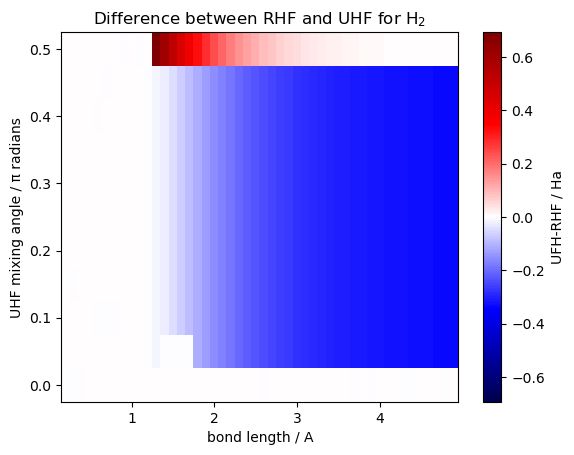

In [41]:
from matplotlib import pyplot as plt

rhf_energies = np.array(rhf_energies)
uhf_energies = np.array(uhf_energies)
fci_energies = np.array(fci_energies)

# Meshgrid for 2d heat plot over two variables
X, Y = np.meshgrid(angles, bond_lengths)

# Reshape UHF energies into the angles - bond_lengths grid
# Reshape RHF so it can be broadcast with UHF in numpy operations
uhf_energies = uhf_energies.reshape(X.shape)
rhf_energies = rhf_energies.reshape((X.shape[0], 1))

# Indexing over None allows UHF to be broadcast with RHF
# UHF has an extra dimension, the mixing angles
uhf_rhf_diff = uhf_energies - rhf_energies

# Angles in terms of pi for ease interpreting figure
angles_per_pi = angles / np.pi

# Parameter sweep values for correctly placing x and y axes ticks
x_inc = bond_lengths[1] - bond_lengths[0]
y_inc = angles_per_pi[1] - angles_per_pi[0]
x_min = bond_lengths.min() - x_inc / 2
y_min = angles_per_pi.min() - y_inc / 2
x_max = bond_lengths.max() + x_inc / 2
y_max = angles_per_pi.max() + y_inc / 2

# Plot heatmap of difference between RHF and UHF
plt.imshow(
    uhf_rhf_diff.transpose(), # transpose puts bond lengths on x-axis
    extent=[x_min, x_max, y_min, y_max],
    origin='lower',
    cmap='seismic',
    vmin=-np.max(abs(uhf_rhf_diff)),  # force symmetric colour scale which gives
    vmax= np.max(abs(uhf_rhf_diff)),  # different colours for positive and negative values
    aspect='auto',
)

plt.colorbar(label="UFH-RHF / Ha")
plt.xlabel("bond length / A")
plt.ylabel("UHF mixing angle / π radians")
plt.title("Difference between RHF and UHF for H$_2$")
plt.show()